### Weight Conversion: 

- This notebook converts the .pkl checkpoint of the official NVIDIA implementation of StyleGAN2-Ada to weights corresponding to the custom StyleGAN2 implementation by [rosinality](https://github.com/rosinality/stylegan2-pytorch) which is used in the e4e architecture and many other inversion technique implementations. 
- For this to work, one needs to load the file [export_weights.py](https://github.com/dvschultz/stylegan2-ada-pytorch/blob/main/export_weights.py) from the stylegan2-ada-pytorch fork by [dvschulz](https://github.com/dvschultz) and place it in the official stylegan2-ada-pytorch repo by NVIDIA. 


In [1]:
import os 
os.chdir('../../stylegan2-ada-pytorch/')

In [2]:
stylegan2_ada_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/network-snapshot-001200.pkl"
model_save_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/e4e/pretrained/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512_network-snapshot-001200.pt"

CMD = f"""
python export_weights.py {stylegan2_ada_path} {model_save_path}
"""
#!{CMD}

### Test the converted weights

In [3]:
os.chdir('../stylegan2-pytorch/')

import torch
from model import Generator
import PIL.Image
import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'

size = 512
latent = 512
n_mlp = 2
channel_multiplier = 2

# Initialize Model
g_ema = Generator(
        size, latent, n_mlp, channel_multiplier=channel_multiplier
    ).to(device)
checkpoint = torch.load(model_save_path)
g_ema.load_state_dict(checkpoint["g_ema"])

<All keys matched successfully>

In [5]:
# Generate some examples
num_samples = 5
sample_z = torch.randn(num_samples, latent, device=device)
generated_converted, _ = g_ema([sample_z])

### Test Identity with original weights

In [6]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()


# Load model architecture
import pickle
experiment_name = "00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512"
experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/{experiment_name}/"
model_name = "network-snapshot-001200.pkl"
model_path = experiment_path + model_name

In [7]:
os.chdir('../stylegan2-ada-pytorch/')
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    G = architecture['G_ema'].to(device)  # torch.nn.Module 
    D = architecture['D'].to(device)

In [8]:
def plot_generated(image):
    img = image.reshape([1,3,512,512])
    img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img_out = PIL.Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')
    return img_out

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


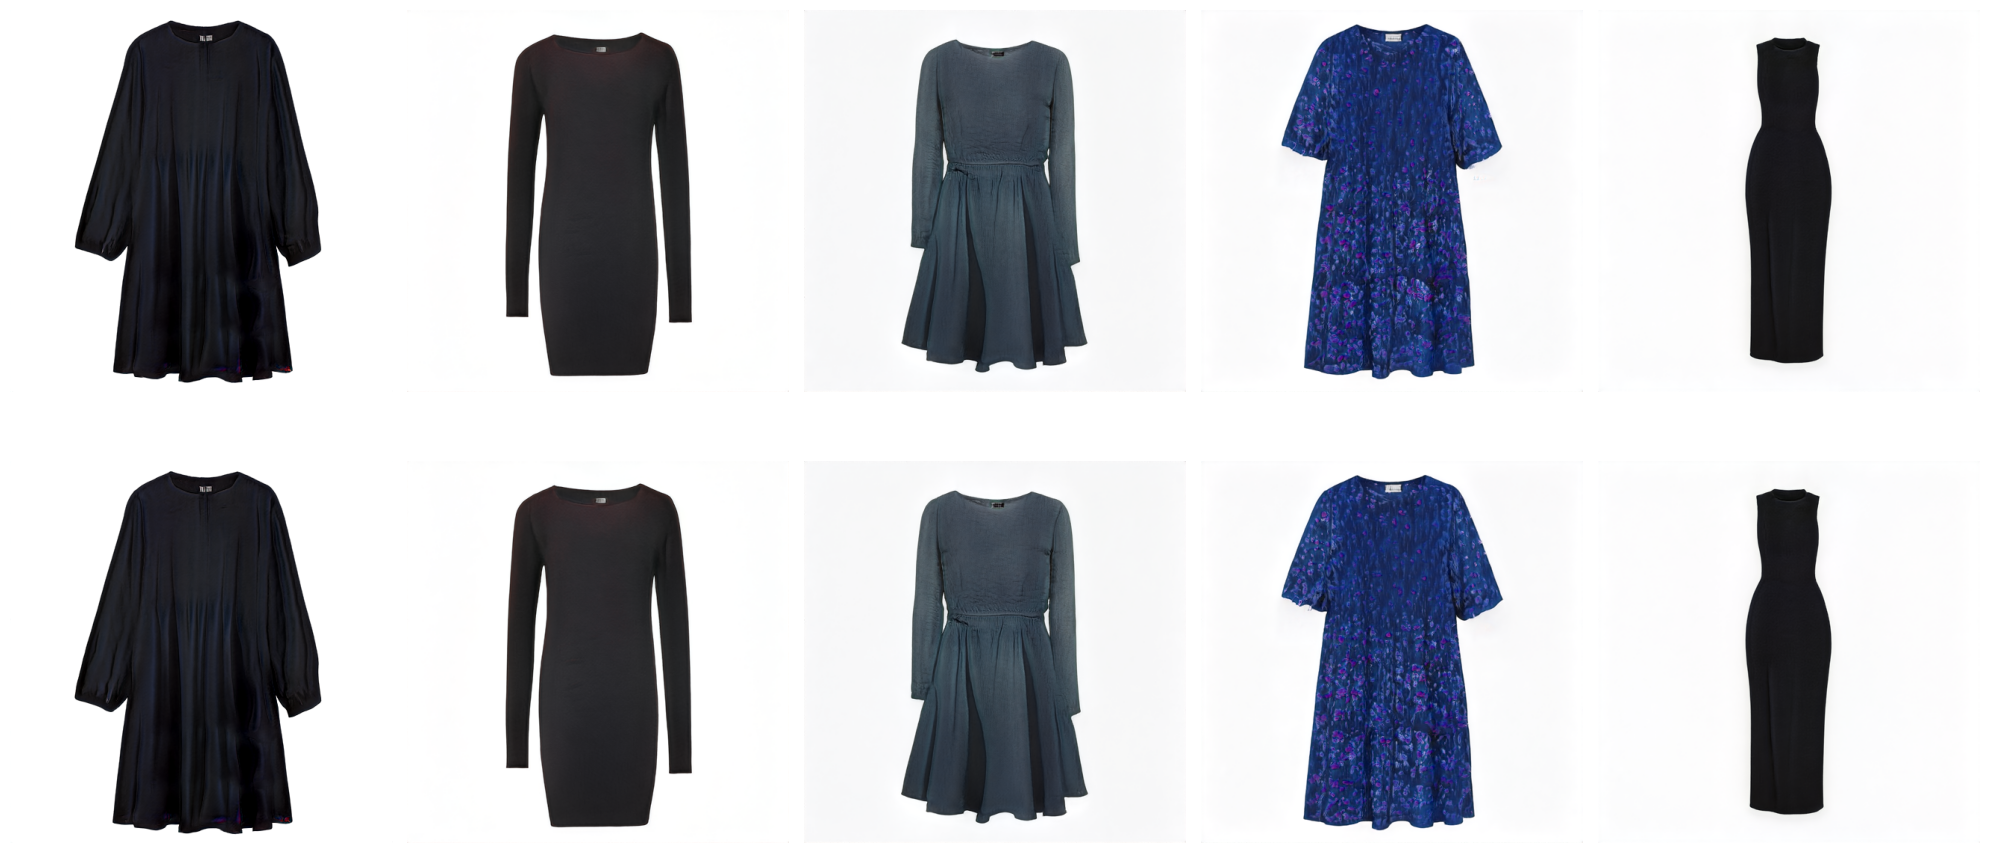

In [9]:
num_samples = 5
sample_z = torch.randn(num_samples, latent, device=device)

# Generate some examples from converted weights
generated_converted, _ = g_ema([sample_z])

# Generate some examples from original weights
generated_orig_model = G(sample_z, None, noise_mode='const')

fig, ax = plt.subplots(2, num_samples, figsize = (20, num_samples*2))
for i in range(num_samples):
    ax[0,i].imshow(plot_generated(generated_converted[i,:,:,:]))
    ax[0,i].axis('off')
    ax[1,i].imshow(plot_generated(generated_orig_model[i,:,:,:]))
    ax[1,i].axis('off')
fig.tight_layout()
plt.show()